In [2]:
pip install pynufft

  Obtaining dependency information for pynufft from https://files.pythonhosted.org/packages/6c/b6/9c6d39a41ed555fbed1668c73c6ab28b474a054efcf8100c642294ed365d/pynufft-2024.1.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB 1.3 MB/s eta 0:00:13
   ---------------------------------------- 0.1/16.2 MB 1.1 MB/s eta 0:00:15
    --------------------------------------- 0.4/16.2 MB 3.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.0/16.2 MB 6.6 MB/s eta 0:00:03
   --- ------------------------------------ 1.5/16.2 MB 7.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.9/16.2 MB 8.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.9/16.2 MB 9.2 MB/s eta 0:00:02
   -------- ------------------------------- 3.5/16.2 MB 10.0 MB/s eta 0:00:02
   --------- ------------------------------ 4.0/16.2 MB 9.8 MB/s eta 0:00:02
   ----------- -------------------

## Nonuniform FFT


采样率 = 345.02712477396017 Hz


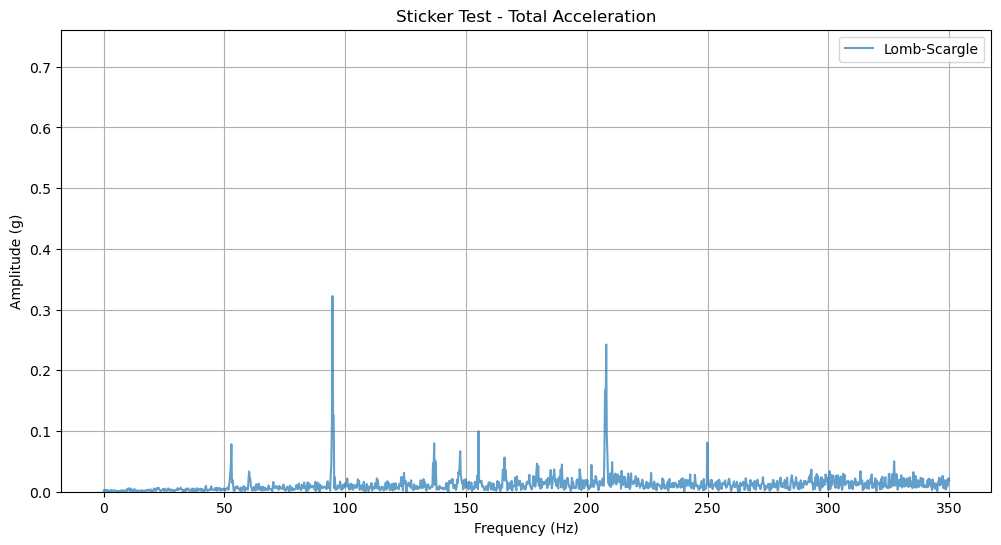


平均采样率: 345.03 Hz


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend, lombscargle

# Read CSV file
file_name = r'double_sticker\250hz_4.csv'
df = pd.read_csv(file_name)
x = df.iloc[50:, 0].values * 0.001  # time in seconds
y1 = df.iloc[50:, 1].values
y2 = df.iloc[50:, 2].values
y3 = df.iloc[50:, 3].values

y_total = np.sqrt(y1**2 + y2**2 + y3**2)

def perform_spectral_analysis(y, x_values):
    # 去除趋势并应用窗函数
    y_detrended = detrend(y)
    N = len(y)
    window = np.hanning(N)
    y_windowed = y_detrended * window
    
    # 计算采样间隔
    dt = np.mean(np.diff(x_values))
    print("采样率 =", 1/dt, "Hz")
    
    # Lomb-Scargle分析
    freqs = np.linspace(0.01, 350, N//2)  # 限制到奈奎斯特频率
    angular_freqs = 2 * np.pi * freqs
    pgram = lombscargle(x_values, y_windowed, angular_freqs)
    amp_ls = np.sqrt(4 * pgram / (N * np.sum(window**2)/N))
    
    # FFT分析
    yf = np.fft.fft(y_windowed)
    xf = np.fft.fftfreq(N, dt)[:N//2]
    amp_fft = np.abs(yf[1:N//2]) * 2.0 / (N * np.sum(window)/N)
    
    return freqs, amp_ls, xf[1:], amp_fft

def plot_spectral_comparison(y, x_values, label):
    freqs_ls, amp_ls, freqs_fft, amp_fft = perform_spectral_analysis(y, x_values)
    
    plt.figure(figsize=(12, 6))
    plt.plot(freqs_ls, amp_ls, label='Lomb-Scargle', alpha=0.7)
    #plt.plot(freqs_fft, amp_fft, label='FFT', alpha=0.7)
    plt.title(f'Sticker Test - {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (g)')
    #plt.xlim(38,42)
    plt.legend()
    plt.grid(True)
    #plt.xlim(398,402)
    # 添加y轴范围限制以更好地显示主要频率成分
    plt.ylim(0, max(np.max(amp_ls), np.max(amp_fft)) * 1.1)
    
    # 可选：添加主要频率标注
    peak_threshold = 0.1 * max(np.max(amp_ls), np.max(amp_fft))
    
    
    plt.show()

# 分析每个方向的数据
plot_spectral_comparison(y_total, x, 'Total Acceleration')

# 打印平均采样率
dt = np.mean(np.diff(x))
print(f"\n平均采样率: {1/dt:.2f} Hz")

In [28]:

df = pd.read_csv(r'SD_Test2\SD_200HZ.TXT')

# 创建图形
plt.figure(figsize=(15, 8))

# 绘制三个方向的加速度
plt.plot(df['Timestamp'], df['X_Acceleration'], label='X方向', alpha=0.7)
plt.plot(df['Timestamp'], df['Y_Acceleration'], label='Y方向', alpha=0.7)
plt.plot(df['Timestamp'], df['Z_Acceleration'], label='Z方向', alpha=0.7)

# 设置图形属性
plt.title('Three-Axis Acceleration Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration(g)')
plt.grid(True)
#plt.xlim(4000, 6190)
#plt.ylim(-1.1,0.25)
plt.legend()

# 显示图形
plt.show()


KeyError: 'Timestamp'

<Figure size 1500x800 with 0 Axes>

## Uniform FFT


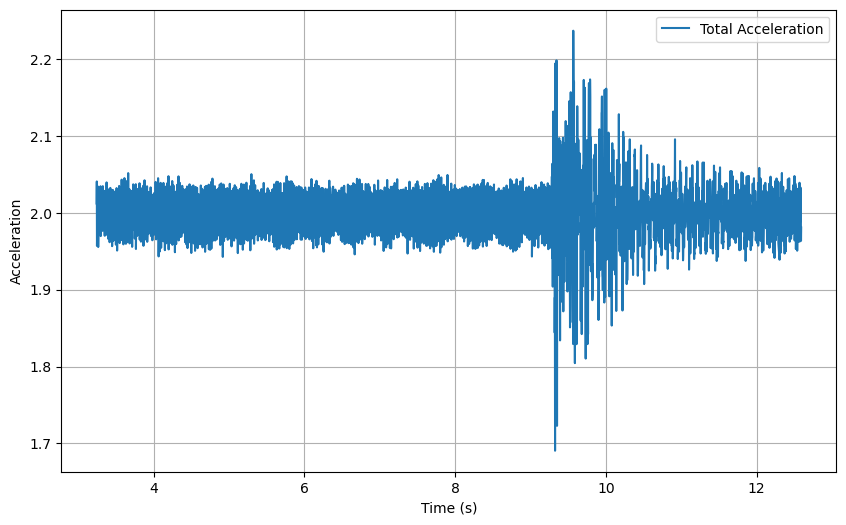

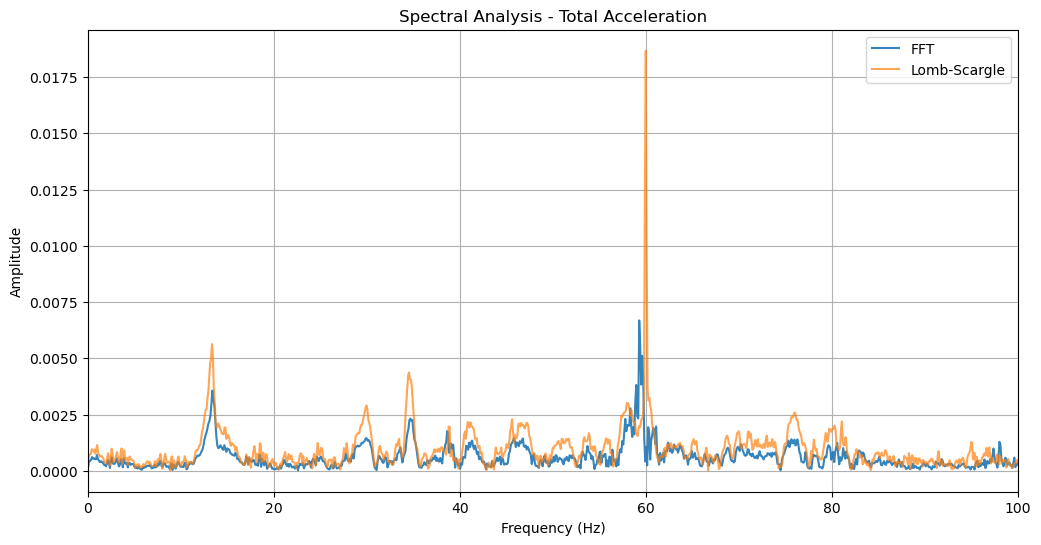

平均采样率: 396.48 Hz


In [51]:
from scipy.signal import detrend, lombscargle

# 读取数据
file_name = r'SD_Test2\SD_60HZ.TXT'
df = pd.read_csv(file_name)

# 提取数据
x = df.iloc[:, 0].values * 0.000001  # 时间
y1 = df.iloc[:, 1].values
y2 = df.iloc[:, 2].values
y3 = df.iloc[:, 3].values

# 计算合成加速度
y_total = np.sqrt(y1**2 + y2**2 + y3**2)

# 计算平均时间间隔
dt = np.mean(np.diff(x))

def plot_spectral_analysis(y, x_values, dt, label):
    # 去除线性趋势并应用窗函数
    y_detrended = detrend(y)
    N = len(y)
    window = np.hanning(N)
    y_windowed = y_detrended * window
    
    # FFT分析
    yf = np.fft.fft(y_windowed)
    xf = np.fft.fftfreq(N, dt)[:N//2]
    amp_fft = 2.0/N * np.abs(yf[:N//2])
    
    # Lomb-Scargle分析
    freqs = np.linspace(0.01, 180, N//2)  # 限制到奈奎斯特频率
    angular_freqs = 2 * np.pi * freqs
    pgram = lombscargle(x_values, y_windowed, angular_freqs)
    amp_ls = np.sqrt(4 * pgram / (N * np.sum(window**2)/N))
    
    # 绘制频谱对比
    plt.figure(figsize=(12, 6))
    plt.plot(xf, amp_fft, label='FFT', alpha=0.9)
    plt.plot(freqs, amp_ls, label='Lomb-Scargle', alpha=0.7)
    plt.title(f'Spectral Analysis - {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0,100)
    plt.legend()
    plt.grid(True)
    plt.show()

# 绘制原始合成加速度数据
plt.figure(figsize=(10, 6))
plt.plot(x, y_total, label='Total Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
#plt.xlim(4000, 5000)

plt.legend()
plt.grid(True)
plt.show()

# 进行频谱分析
plot_spectral_analysis(y_total, x, dt, 'Total Acceleration')

# 打印平均采样率
print(f"平均采样率: {1/dt:.2f} Hz")